# Iteration 1 for NOHATE related NLP project

- Christoph Geis-Schroer
- Sebastian Jäger

## Goal

- create training dataset (labeled) with snorkel

## Information

- ~12k comments, different sources
- 500 gold labels (at all, not per label)
- German
- different classes/types of hatespeech (e.g. Intelligenz, Beschimpfung, Entmenschlichung)


## Notes

- focus on full stack example
- built Docker container because of issues with different OS (macOS/ Windows)






## Bootstrapping

imports, initialize snorkel session and connect to the database

In [1]:
# reload external python files before Cell execution
# -> prevent nasty bugs
%load_ext autoreload
%autoreload 2

# matplotlib inline plotting
%matplotlib inline

# activate jupyters tab completion
%config IPCompleter.greedy=True


# bootstrapping -> imports and connect to database
from utils.bootstrap import *


## Preprocessing

Parse test file corpus into documents and sentences

In [2]:
hate_speech_preprocessor = HateSpeechPreprocessor('../data/vico_user_comments.csv')
corpus_parser = CorpusParser(parser=Spacy(lang="de"))

%time corpus_parser.apply(hate_speech_preprocessor)

Clearing existing...
Running UDF...
CPU times: user 2min 1s, sys: 3.78 s, total: 2min 5s
Wall time: 2min 10s



## Candidate Extraction

Three different subclasses are used:

- `Intelligenz_BB3c`

- `Beschimpfung_BB6a`

- `Entmenschlichung_BB6e`

In [3]:
# Candidates are imported in bootstrapping-script


### Create `CandidateExtractor` for each subclass

Extraction is based on signal words that are often used. Use `RegexMatchEach` to find all potential candidates.

In [4]:
# imports the dictionaries with signal words
from utils.dictionaries import *

intelligenz_regex      = make_regex(intelligenz_signal_words)
beschimpfung_regex     = make_regex(beschimpfung_signal_words)
entmenschlichung_regex = make_regex(entmenschlichung_signal_words, animal_signal_words)

candidate_regex_tupels = [
    (Intelligenz_BB3c, intelligenz_regex),
    (Beschimpfung_BB6a, beschimpfung_regex),
    (Entmenschlichung_BB6e, entmenschlichung_regex)
]
        
candidate_extractors = []

for candidate_class, candidate_regex in candidate_regex_tupels:

    n_grams             = Ngrams(n_max = 5)
    matcher             = RegexMatchEach(rgx = candidate_regex)
    candidate_extractor = CandidateExtractor(candidate_class, [n_grams], [matcher])
        
    candidate_extractors.append((candidate_class, candidate_extractor))


### Split Data

Split data into train/dev/test split with ratio: 80/10/10 %

In [5]:
documents = session.query(Document).order_by(Document.name).all()

train_sentences = set()
dev_sentences   = set()
test_sentences  = set()

for index, document in enumerate(documents):
    for sentence in document.sentences:
        if index % 10 == 8:
            dev_sentences.add(sentence)
        elif index % 10 == 9:
            test_sentences.add(sentence)
        else:
            train_sentences.add(sentence)
            
print("Documents:", session.query(Document).count())
print("Sentences:", session.query(Sentence).count())

Documents: 11715
Sentences: 71041



### Run extractors

In [6]:
%%time

# delete all candidates
print("Clearing database ...\n")

if session.query(Candidate).count() != 0:
    session.query(Candidate).delete()

if session.query(Intelligenz_BB3c).count() != 0:
    session.query(Intelligenz_BB3c).delete()
        
if session.query(Beschimpfung_BB6a).count() != 0:
    session.query(Beschimpfung_BB6a).delete()

if session.query(Entmenschlichung_BB6e).count() != 0:
    session.query(Entmenschlichung_BB6e).delete()


print("Extracting Candidates ...\n")

for candidate_class, candidate_extractor in candidate_extractors:
    for split, sentence in enumerate([train_sentences, dev_sentences, test_sentences]):
            
        candidate_extractor.apply(sentence, split=split, clear=False)
        print(f"Number of {candidate_class.__name__} candidates in split {split}: {session.query(candidate_class).filter(candidate_class.split == split).count()}\n\n")

Clearing database ...

Extracting Candidates ...

Running UDF...
[========================================] 100%

Number of Intelligenz candidates in split 0: 940


Running UDF...
[========================================] 100%

Number of Intelligenz candidates in split 1: 144


Running UDF...
[========================================] 100%

Number of Intelligenz candidates in split 2: 117


Running UDF...
[========================================] 100%

Number of Beschimpfung candidates in split 0: 351


Running UDF...
[========================================] 100%

Number of Beschimpfung candidates in split 1: 36


Running UDF...
[========================================] 100%

Number of Beschimpfung candidates in split 2: 51


Running UDF...
[========================================] 100%

Number of Entmenschlichung candidates in split 0: 440


Running UDF...
[========================================] 100%

Number of Entmenschlichung candidates in split 1: 55


Running UDF...
[====


### Some Further Notes

Ideas to improve the Candidate Extraction Process

- capital letters are all (input as well as regex) forced to be lower case. -> phrases like "OHNE" are not foundable based one only capital letters, at least with regex matcher
- Use online Dicts for matching "negative" words .. (https://www.wertesysteme.de/nuetzliche-infos/arten-von-wertebegriffe/liste-negativer-werte/)
- Fuzzy search


## Labeling Functions

1. create `Labeling Functions`
2. collect into a list of `Labeling Functions`
3. label all candidates in split 0 (train split)
4. show some statistics

In [7]:
from utils.labeling_functions import *

L_train = []

print("Clear existing ...")
## clear existing labels
for index in range(len(candidate_classes)):
    LabelAnnotator(lfs=[]).clear(session, split = 0, key_group = index)

# hack to unlock database
session.commit()

for index, candidate_class in enumerate(candidate_classes):
    L_train.append(LabelAnnotator(lfs=labeling_functions_all[index]).apply(split=0, key_group = index, clear = False, cids_query = session.query(candidate_class.id).filter(candidate_class.split == 0)))
    
print(L_train)

Clear existing ...
Running UDF...
[========================================] 100%

Running UDF...
[========================================] 100%

Running UDF...
[========================================] 100%

[<940x5 sparse matrix of type '<class 'numpy.int64'>'
	with 1585 stored elements in Compressed Sparse Row format>, <351x4 sparse matrix of type '<class 'numpy.int64'>'
	with 560 stored elements in Compressed Sparse Row format>, <440x4 sparse matrix of type '<class 'numpy.int64'>'
	with 715 stored elements in Compressed Sparse Row format>]


* **Coverage** is the fraction of candidates that the labeling function emits a non-zero label for.
* **Overlap** is the fraction candidates that the labeling function emits a non-zero label for and that another labeling function emits a non-zero label for.
* **Conflict** is the fraction candidates that the labeling function emits a non-zero label for and that another labeling function emits a *conflicting* non-zero label for.


## Generativ Model

Unify labeling functions to _model_ a generative model, which Snorkel will help to easily apply.
This will ultimately produce a single set of **noise-aware training labels**. -> Technical details: [NIPS 2016 paper](https://arxiv.org/abs/1605.07723)

1. train `GenerativeModel`
2. "predict" labels for the train dataset
3. save the marginals
4. show some statistics


### About the Terminology

- Marginals: "noise-aware training labels"


_**Parameter Definitions**_

- **epochs:**     A single pass through all the data in your training set
- **step_size:**  The factor by which we update model weights after computing the gradient
- **decay:**      The rate our update factor dimishes (decay) over time.

In [8]:
L_train = []
marginals = []
generativ_models = []

for index, candidate_class in enumerate(candidate_classes):
    L_train.append(LabelAnnotator(lfs = []).load_matrix(session, split=0, key_group = index, cids_query = session.query(candidate_class.id).filter(candidate_class.split == 0)))

print(L_train, "\n")

for index, candidate_classe in enumerate(candidate_classes):
    generativ_models.append(GenerativeModel())

    decay=0.95
    epochs=100
    reg_param=1e-6
    step_size=0.1 / L_train[index].shape[0]

    generativ_models[index].train(L_train[index], epochs = epochs, decay = decay, step_size = step_size, reg_param = reg_param)
    marginals.append(generativ_models[index].marginals(L_train[index]))

    print(f"Class {index + 1} {candidate_classe.__name__} -> {len(marginals[index])}")

# Saving marginals in database is not possible because snorkel cannot distiguish (in database) the different candidate classes

[<940x5 sparse matrix of type '<class 'numpy.int64'>'
	with 1585 stored elements in Compressed Sparse Row format>, <351x4 sparse matrix of type '<class 'numpy.int64'>'
	with 560 stored elements in Compressed Sparse Row format>, <440x4 sparse matrix of type '<class 'numpy.int64'>'
	with 715 stored elements in Compressed Sparse Row format>] 

Inferred cardinality: 2
Class 1 Intelligenz -> 940
Inferred cardinality: 2
Class 2 Beschimpfung -> 351
Inferred cardinality: 2
Class 3 Entmenschlichung -> 440


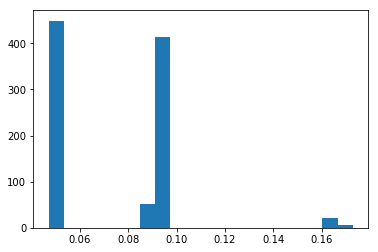

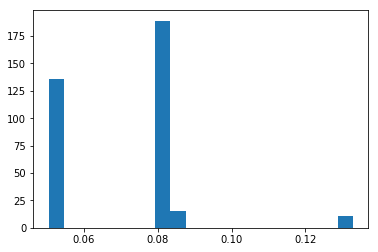

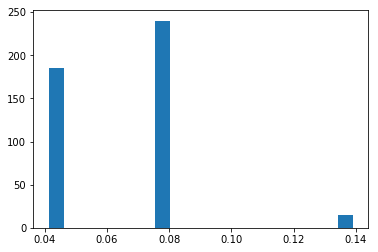

In [9]:
for marginal in marginals:
    plt.hist(marginal, bins=20)
    plt.show()

In [10]:
generativ_models[0].learned_lf_stats()

,Accuracy,Coverage,Precision,Recall
0,0.492016,0.6701,0.480465,0.326510
1,0.340819,0.6813,0.339447,0.236319
2,0.909627,0.7801,0.908807,0.706931
3,0.507882,0.6661,0.508793,0.340089
4,0.540204,0.6753,0.532263,0.362789


In [11]:
generativ_models[1].learned_lf_stats()

,Accuracy,Coverage,Precision,Recall
0,0.500605,0.6608,0.493237,0.334080
1,0.383752,0.6684,0.377545,0.256718
2,0.922063,0.7814,0.919326,0.721498
3,0.511460,0.6632,0.499398,0.337948


In [12]:
generativ_models[2].learned_lf_stats()

,Accuracy,Coverage,Precision,Recall
0,0.515092,0.6593,0.532135,0.337454
1,0.342882,0.6772,0.357873,0.230056
2,0.926626,0.7932,0.934446,0.735175
3,0.504167,0.6720,0.521905,0.342863


### Some Further Notes

- Use Grid Search (`RandomSearch`) -> Workshop 3



## Creating a .txt-File suitable for FastText

1. load candidates and corresponding marginals
2. split by given 'threshold'
3. add labels, so each line in the text-file starts with one of:
    - \_label\_hatespeech
    - \_label\_nohatespeech

4. shuffel the lines and write as .txt file
    

In [13]:
# hand crafted based on above histograms
dataset_lines = []

for index, candidate_class in enumerate(candidate_classes):

    marginals_split_0  = marginals[index]
    candidates_split_0 = session.query(candidate_class).filter(candidate_class.split == 0).all()

    hatespeech_sentences = []
    no_hatespeech_sentences = []

    for candidate, marginal in zip(candidates_split_0, marginals_split_0):
        if marginal > marginals_split_0.mean():
            hatespeech_sentences.append(f"__label__hate\t{candidate.get_parent().text}")
        else:
            no_hatespeech_sentences.append(f"__label__nohate\t{candidate.get_parent().text}")

    dataset_lines.extend(hatespeech_sentences)
    dataset_lines.extend(no_hatespeech_sentences)

    # shuffel the lines
    random.shuffle(dataset_lines)
        
# finally write dataset
with open("../data/dataset_binary_classification_gesnorkelt.txt", "w") as file:
    file.writelines("\n".join(dataset_lines))



## Convert Gold Labeled Testset

Actual classes are: 

- Intelligenz (BB3c)
- Beschimpfung (BB6a)
- Entmenschlichung (BB6e)

If one of these clases set -> hatespeech

In [9]:
gold_labeled_test_set = pd.read_csv("../data/comments_bewertungen_fu_berlin_original.csv")

In [10]:
select_classes = (gold_labeled_test_set["BB3c"] == "1") | (gold_labeled_test_set["BB6a"] == "1") | (gold_labeled_test_set["BB6e"] == "1") | (gold_labeled_test_set["BB3i"] == "1") | (gold_labeled_test_set["BB4"] == "11") | (gold_labeled_test_set["BB4"] == "12") | (gold_labeled_test_set["BB4"] == "13")

hate_speech_comments =    gold_labeled_test_set[select_classes]
no_hate_speech_comments = gold_labeled_test_set[select_classes == False] # all others

In [11]:
lines = [f"__label__hate\t{item}" for item in hate_speech_comments["b_string"]]
lines.extend([f"__label__nohate\t{item}" for item in no_hate_speech_comments["b_string"]])

In [12]:
with open("../data/gold_label_testset_binary_by_dimension.txt", "w") as file:
    file.writelines("\n".join(lines))


# Fasttext Baseline

## Train Fasttext Classification

In [18]:
%%bash

fasttext supervised -input ../data/dataset_binary_classification_gesnorkelt.txt -output fasttext_model_binary_classification

Read 0M words
Number of words:  8556
Number of labels: 2
Progress: 100.0% words/sec/thread:  169794 lr:  0.000000 loss:  0.127194 ETA:   0h 0m


In [19]:
%%bash

fasttext test fasttext_model_binary_classification.bin ../data/gold_label_testset.txt

N	500
P@1	0.284
R@1	0.284


In [20]:
%%bash

echo "Some testing sentences ..."
echo
cat ../data/for_example_predictions.txt
echo; echo


fasttext predict fasttext_model_binary_classification.bin ../data/for_example_predictions.txt

Some testing sentences ...

Eine junge Frau verlässt Deutschland, weil Deutschland mal wieder jedes kriminelle Assipack reinspazieren lässt.
Der hat doch den A.... offen.
Linker Abschaum
Ich mag alle menschen auch asylaten!
Dieser Schrott soll garnicht erst nach Deutschland hereingelassen werden
Liebe <3
Noch ein langweiliger Satz.

__label__hate
__label__hate
__label__hate
__label__hate
__label__hate
__label__hate
__label__nohate


# Next Steps (Ideas)

- improve candidate extraction
    - include all three labels in the labeled training data set
- write (more) labeling functions
- improve generative model
- create proper baseline model with FastText
- include more hate speech classes


- maybe other models 

- error classes:
    - quoting hate speech
    - usernames with hate speech content
    - self-offense

- find useful lists
- class distribution of labeled data
- list of comments we aren't sure about
